### Script Setup

In [ ]:
# Required libraries

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

In [ ]:
# Global variables used throughout script - CHANGE IF NEEDED

# Image Properties 
img_width = 1200       # width to crop original image to
img_height = 1200      # height to crop original image to    
classes = ['normal', 'pneumonia']

# Other Values/Flags
random_seed_val = 42  # set random seeds
use_cuda = True       # enable GPU usage
balance_data = False  # balance out normal/pneumonia samples in training dataset
augment_data = True   # augment normal samples and add on to original training set
load_feat = True      # load AlexNet features
re_extract_feat = False # re-extract AlexNet features

# Global Paths
dataset_location = '/content/gdrive/My Drive/APS360/Project_37/data_processing/project/'        # dataset location
alnxfeat_location = '/content/gdrive/My Drive/APS360/Project_37/data_processing/AlexNetFeatures2835each/'   # AlexNet features location

# Model Hyperparameters
batch_size = 128
num_epochs = 3
num_workers = 1 
learning_rate = 0.0008

Saved AlexNet Features: 

1. 1200x1200 crop, 227x227 resize, normal samples augmented, final ratio 2835:2835
'/content/gdrive/My Drive/APS360/Project_37/data_processing/AlexNetFeatures2835each/'

2. 840x840 crop, 227x227 resize, no augmentation/balance, final ratio 915:2835
'/content/gdrive/My Drive/APS360/Project_37/data_processing/AlexNetFeatures915to2835/'

In [ ]:
# Since images are saved on Google Drive, need to mount gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Data Loading 
Includes balancing out pneumonia/healthy samples (915 normal/915 pneumonia, if specified), augmenting dataset (2835 normal/2835 pneumonia, if specified), cropping, resizing and creating dataloaders.

In [ ]:
# Function to visualize dataset
def display_images(dataset, num_images):
  
  loader = torch.utils.data.DataLoader(dataset, batch_size=num_images)
  dataiter = iter(loader)
  images, labels = dataiter.next()
  images = images.numpy() # convert images to numpy for display

  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(15, 7))
  for idx in np.arange(num_images):
      ax = fig.add_subplot(2, 3, idx+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(images[idx], (1, 2, 0)))
      ax.set_title(classes[labels[idx]])

In [ ]:
# Create training, validation and test dataloaders

if not load_feat:
  # Define a transform function that resizes images to img_width x img_height
  transform = torchvision.transforms.Compose([torchvision.transforms.CenterCrop((img_width, img_height)),
                                              torchvision.transforms.Resize((227, 227)), 
                                              torchvision.transforms.ToTensor()])

  # Load training, validation and test data from Google Drive
  train_data = torchvision.datasets.ImageFolder(dataset_location+'train', transform=transform)
  val_data = torchvision.datasets.ImageFolder(dataset_location+'val', transform=transform)
  test_data = torchvision.datasets.ImageFolder(dataset_location+'test', transform=transform)

  # display_images(train_data, 3)

  # Data Processing

  # Balance normal/pneumonia samples without augmenting data
  if balance_data:
    print("Balancing Data...")
    train_indices = list(range(-915, 915))
    train_data = torch.utils.data.Subset(train_data, train_indices)

  # Create augmented dataset
  elif augment_data:
    print("Augmenting Data...")
    
    # Training Data is augmented using three techniques
    aug_tactics = [torchvision.transforms.RandomRotation(10),                   # rotate images by random angle between 0 and 10 degrees
                  torchvision.transforms.RandomAffine(degrees=0, 
                                                      translate=(0.02, 0.02)), # shift pixels by random number between 0 and 0.01*img_width pixels horizontally/vertically
                  torchvision.transforms.GaussianBlur(101, (0.1, 1))]           # blur images with randomly chosen Gaussian blur

    # Array to hold augmented data
    aug_train_data = []
    for i in range(0, 3):

      if i == 2:
        end_index = 90
      else:
        end_index = 915

      # Apply augmentation to the training dataset
      transform = torchvision.transforms.Compose([aug_tactics[i],
                                                  torchvision.transforms.CenterCrop((img_width, img_height)),
                                                  torchvision.transforms.Resize((227, 227)),
                                                  torchvision.transforms.ToTensor()])

      # Discard augmented pneumonia samples and keep a specific number of augmented healthy samples
      aug_train_data.append(torchvision.datasets.ImageFolder(dataset_location+'train', transform=transform))
      aug_train_data[i] = torch.utils.data.Subset(aug_train_data[i], list(range(0, end_index)))

      # display_images(aug_train_data[i], 3)

    # Create bigger set of training data
    train_data = torch.utils.data.ConcatDataset([train_data, aug_train_data[0], aug_train_data[1], aug_train_data[2]])

  #Verify splitting of the dataset
  print('train:')
  print(len(train_data))
  print('val:')
  print(len(val_data))
  print('test:')
  print(len(test_data))

In [ ]:
# Prepare Dataloaders

if not load_feat:
  torch.manual_seed(random_seed_val)
  train_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size=1,
                                            num_workers=num_workers,
                                            shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                          batch_size=1,
                                          num_workers=num_workers,
                                          shuffle=True)

  test_loader = torch.utils.data.DataLoader(test_data,
                                            batch_size=1,
                                            num_workers=num_workers,
                                            shuffle=True)

### AlexNet Feature Extraction
Includes functions to compute/save features and load saved features from Google Drive

In [ ]:
# Load pre-trained AlexNet model
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
# Save features to folder as tensors

def save_features(loader, data_type):
  n = 0
  for img, label in loader:
      features = alexnet.features(img)
      features_tensor = torch.from_numpy(features.detach().numpy())

      folder_name = alnxfeat_location + data_type + str(classes[label])
      if not os.path.isdir(folder_name):
          os.mkdir(folder_name)
      torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
      n += 1

In [ ]:
# Save AlexNet features

if re_extract_feat and not load_feat:
  save_features(train_loader, '/alex_train/')
  save_features(val_loader, '/alex_val/')
  save_features(test_loader, '/alex_test/')

In [ ]:
def load_features(folder, master_path, batch_size):
  dir = master_path + '/' + str(folder)
  dataset = torchvision.datasets.DatasetFolder(dir, loader=torch.load, extensions=('.tensor'))
  loader = torch.utils.data.DataLoader(dataset,
                                       batch_size=batch_size, 
                                       num_workers=1, 
                                       shuffle=True)
  return loader

In [ ]:
# Load AlexNet features in batches

if load_feat:
  train_loader = load_features('alex_train', alnxfeat_location, batch_size)
  val_loader = load_features('alex_val', alnxfeat_location, batch_size)
  test_loader = load_features('alex_test', alnxfeat_location, 1)

### ANN Classifier

In [ ]:
# Define classifier
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(256*6*6, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = x.view(-1, 256*6*6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Model Training
Includes functions to train model and calculate accuracy

In [ ]:
# Training function
def train(model, batch_size=32, num_epochs=1, learning_rate=0.009):

    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_acc, val_acc, iters, train_losses, val_losses = [], [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for imgs, labels in iter(train_loader):
          
            
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

          
            out = model(imgs)             # forward pass
            # print(out)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch



            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole trainig set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = imgs.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
            iters.append(n)
            train_losses.append(float(loss)/batch_size)             # compute *average* loss
            # train_acc.append(get_accuracy(model, train=True))
            vacc, vloss = get_accuracy(model, criterion, train=False)  # compute validation accuracy and loss
            val_acc.append(vacc)
            val_losses.append(vloss)
            
            n += 1
            mini_b += 1
            print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)), "Current Training Accuracy: {}".format(train_acc[-1]), "Current Validation Accuracy: {}".format(val_acc[-1]))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_losses, label="Training")
    plt.plot(iters, val_losses, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, criterion, train=True))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))


In [ ]:
# Calculating accuracy function
def get_accuracy(model, criterion, train=False):
    if train:
        data_loader = train_loader
    else:
        data_loader = val_loader

    correct = 0
    loss = 0.0
    total = 0
    for imgs, labels in data_loader:
        
         
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        if not train:
          loss += float(criterion(output, labels))

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total, loss / total

CUDA is available!  Training on GPU ...
Iteration:  1 Progress:   2.22  % Time Elapsed:  170.01 s 
Iteration:  2 Progress:   4.44  % Time Elapsed:  171.12 s 
Iteration:  3 Progress:   6.67  % Time Elapsed:  172.20 s 
Iteration:  4 Progress:   8.89  % Time Elapsed:  194.67 s 
Iteration:  5 Progress:  11.11  % Time Elapsed:  217.44 s 
Iteration:  6 Progress:  13.33  % Time Elapsed:  240.18 s 
Iteration:  7 Progress:  15.56  % Time Elapsed:  263.58 s 
Iteration:  8 Progress:  17.78  % Time Elapsed:  288.50 s 
Iteration:  9 Progress:  20.00  % Time Elapsed:  311.47 s 
Iteration:  10 Progress:  22.22  % Time Elapsed:  334.46 s 
Iteration:  11 Progress:  24.44  % Time Elapsed:  357.37 s 
Iteration:  12 Progress:  26.67  % Time Elapsed:  380.37 s 
Iteration:  13 Progress:  28.89  % Time Elapsed:  403.71 s 
Iteration:  14 Progress:  31.11  % Time Elapsed:  426.92 s 
Iteration:  15 Progress:  33.33  % Time Elapsed:  449.96 s 
Iteration:  16 Progress:  35.56  % Time Elapsed:  472.77 s 
Iteration

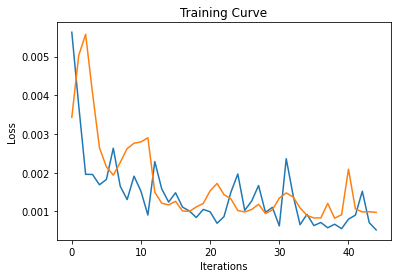

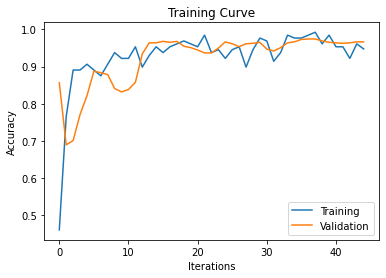

Final Training Accuracy: (0.9717813051146384, 0.0)
Final Validation Accuracy: 0.9663648124191462
Total time:   1182.01 s  Time per Epoch:  1182.01 s 


In [ ]:
# Main Training Code
model = ANNClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train(model, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate)

In [ ]:
# Save Model State
torch.save(model.state_dict(), alnxfeat_location + 'model_state_12052020.pth')


<All keys matched successfully>

### Final Test on Holdout Data

In [ ]:
def get_results(model, dataloader):
  
  coeff_mat = np.zeros((2,2))
  num_samples = [0, 0]
  correct = 0
  total = 0 

  start_time = time.time()

  for imgs, labels in iter(dataloader):
    num_samples[labels] += 1

    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    
    # Calculate accuracy
    output = model(imgs)
    
    # Select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]

    # Update confusion matrix
    coeff_mat[pred][labels] += 1
  
  time_passed = time.time() - start_time
  print("Time to Evaluate Test Data: % 6.2f s" % time_passed)

  # Normalize the confusion matrix
  coeff_mat[0][0] = coeff_mat[0][0] / num_samples[0]
  coeff_mat[1][0] = coeff_mat[1][0] / num_samples[0]
  coeff_mat[0][1] = coeff_mat[0][1] / num_samples[1]
  coeff_mat[1][1] = coeff_mat[1][1] / num_samples[1]
  
  #precision and recall
  #based on: https://medium.com/@shubhamkabre/step-by-step-solution-of-deep-learning-for-pneumonia-detection-from-chest-x-ray-images-5bb272eb8548
  if (coeff_mat[0][0] + coeff_mat[0][1])!=0 and (coeff_mat[0][0], coeff_mat[1][0])!=0:
    precision= round((coeff_mat[0][0] / (coeff_mat[0][0] + coeff_mat[0][1]))*100, 2) 
    recall   = round((coeff_mat[0][0] / (coeff_mat[0][0] + coeff_mat[1][0]))*100, 2) 
    print('Precision Score:', precision, '%')
    print('Recall Score:', recall, '%')


  print("Accuracy:", correct/total)
  print("Normalized Confusion Matrix:\n", coeff_mat)


In [ ]:
get_results(model, test_loader)

Time to Evaluate Test Data:  92.97 s
Precision Score: 97.96 %
Recall Score: 95.45 %
Accuracy: 0.9733009708737864
Normalized Confusion Matrix:
 [[0.95454545 0.01986755]
 [0.04545455 0.98013245]]


###Demo

In [ ]:
# Load Model State
new_model = ANNClassifier()
new_model.cuda()
new_model.load_state_dict(torch.load(alnxfeat_location + 'model_state_12052020.pth'))


<All keys matched successfully>

In [ ]:
demo_data_loc = '/content/gdrive/My Drive/APS360/Project_37/data_processing/Demo/'

# Generate AlexNet features for demo images

# for imgs, labels in demo_data:
#   #demo_features.append( (alexnet.features(imgs.view(1, 3, 227, 227)), labels) )

#   n = 0
#   demo_features = alexnet.features(imgs.view(1, 3, 227, 227))
#   df_tensor = torch.from_numpy(demo_features.detach().numpy())

#   folder_name = demo_data_loc + str(classes[labels])
#   if not os.path.isdir(folder_name):
#     os.mkdir(folder_name)
#   torch.save(df_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
#   n += 1


In [ ]:
# Load AlexNet features for demo

dataset = torchvision.datasets.DatasetFolder(demo_data_loc, loader=torch.load, extensions=('.tensor'))
demo_loader = torch.utils.data.DataLoader(dataset, batch_size=1)

feat = []
for it in iter(demo_loader):
  feat.append(it)

In [ ]:
# Function to help output model predictions in human readable form
def make_prediction(model, imgs, labels):

    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    
    # Calculate model prediction
    output = model(imgs)
    pred = output.max(1, keepdim=True)[1]

    print("Model Prediction for Image {}: {}".format(it+1, classes[pred].upper()))
    #time.sleep(10)
  #print("")
  #get_results(new_model, demo_loader)

# Generate predictions
# make_prediction(new_model, demo_loader)

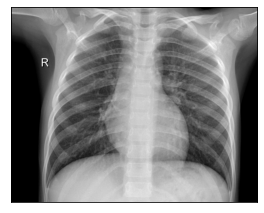

Ground Label for Patient X: NORMAL
Model Prediction for Image 1: NORMAL


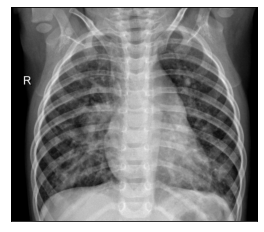

Ground Label for Patient X: PNEUMONIA
Model Prediction for Image 2: PNEUMONIA


In [ ]:
demo_data = torchvision.datasets.ImageFolder(demo_data_loc, transform=torchvision.transforms.ToTensor())

for it, data in enumerate(demo_data, 0):
  images = data[0].numpy()
  labels = data[1]

  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(15, 15))
  ax = fig.add_subplot(2, 3, 1, xticks=[], yticks=[])
  plt.imshow(np.transpose(images, (1, 2, 0)))
  #ax.set_title('Ground Label for Image '+ str(it + 1) + ': ' + classes[labels].upper())

  plt.show()

  print(f"Ground Label for Patient X: {classes[labels].upper()}")
  time.sleep(5)
  make_prediction(new_model, feat[it][0], feat[it][1])
